# <a id='toc1_'></a>[Projet 4, Partie 2 - Construisez un modèle de scoring](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Projet 4, Partie 2 - Construisez un modèle de scoring](#toc1_)    
  - [Train](#toc1_1_)    
  - [Test](#toc1_2_)    
    - [Resultat LDA](#toc1_2_1_)    
    - [Resultat LGM](#toc1_2_2_)    
    - [Resultat NB](#toc1_2_3_)    
- [Optimisation des hyperparametres](#toc2_)    
  - [Optuna](#toc2_1_)    
- [Explication du modèle avec SHAP](#toc3_)    
  - [SHAP](#toc3_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Comme nous l'avons vu dans la partie 1 (voir notebook précedant) notre choix de modèle c'est porte sur les modèles ayant les meilleures metriques a savoir: 

- Linear Discriminant Analysis (LDA)
- LightGBM (LGB)
- Naive Bayes (NB)

Pourquoi ? 

- LDA a les meilleures performance global (AUC, F1, Kappa, MCC)
- LGB a la meilleure precision et une des meilleure Accuracy
- NB a le meilleures recall


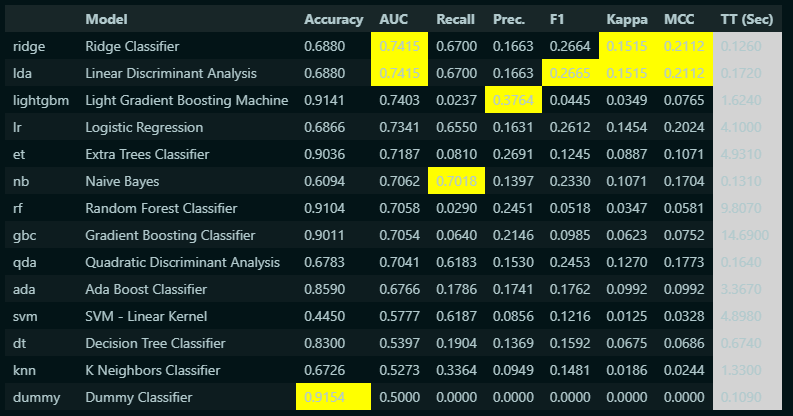

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
from sklearn.naive_bayes import MultinomialNB, GaussianNB  
from lightgbm import LGBMClassifier 
import matplotlib.pyplot as plt
import seaborn as sns
# import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE 
# import optuna
import logging
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

In [2]:
df_origin = pd.read_csv('../data/application_train.csv')
df = df_origin.copy()

In [3]:
class scoringCredit:
    def __init__(self, data , preprocessing_type: str):
        self.data = data
        self.preprocessing_type = preprocessing_type
        self.feature_importance_columns = None
        self.columns_without_context = [
            'SK_ID_CURR',
            'NAME_CONTRACT_TYPE',
            'NAME_TYPE_SUITE',
            'NAME_INCOME_TYPE',
            'NAME_EDUCATION_TYPE',
            'NAME_FAMILY_STATUS',
            'NAME_HOUSING_TYPE',
            'DAYS_ID_PUBLISH',
            'FLAG_EMP_PHONE',
            'FLAG_WORK_PHONE',
            'FLAG_PHONE',
            'FLAG_EMAIL',
            'DAYS_LAST_PHONE_CHANGE',
            'WEEKDAY_APPR_PROCESS_START',
            # 'OCCUPATION_TYPE'


        ]
        
    
    def handleMissingValues(self):
        try:
            # Calcul des valeurs manquantes par columns en %
            missing_percent_cols = (self.data.isna().sum() / len(self.data)) * 100

            # Crée une liste des colonnes ayant plus de 50% de valeurs manquantes
            drop_cols = missing_percent_cols[missing_percent_cols > 40]

            #  supressino des colonnes dans le dataframe
            self.data = self.data.drop(list(drop_cols.index), axis=1)

            # Recuperer toutes les colonnes qui ont encore des valeurs manquantes

            #Imputation avec knn imputer


            self.data = self.data.dropna()

            return self.data

        except Exception as error:
            raise error

        return f'Sucessfuly Delete: {list(drop_cols.index)}'


    def handleCategoricalsData(self):
        try:
            # Features Binaires
            binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

            # Traitement de CODE_GENDER pour supprimer xna
            if 'CODE_GENDER' in self.data.columns:
                self.data['CODE_GENDER'] = self.data['CODE_GENDER'].replace('XNA', pd.NA)

            # Convertir les variables binaires avec get_dummies
            self.data[binary_features] = pd.get_dummies(self.data[binary_features], drop_first=True).astype(int)

            # Features pour target encoding
            target_encoding_features = ['ORGANIZATION_TYPE', 'OCCUPATION_TYPE']
            for feature in target_encoding_features:
                if feature in self.data.columns:
                    target_mean = self.data.groupby(feature)['TARGET'].mean()
                    self.data[feature] = self.data[feature].map(target_mean)

            return self.data

        except Exception as error:
            raise error

        
    def featuresOptimisation(self):
        try:
            # Étape 1 : Colonnes FLAG
            flag_columns = self.data.filter(like='FLAG').columns
            self.data['FLAGS'] = self.data[flag_columns].sum(axis=1)
            self.data.drop(columns=flag_columns, inplace=True)

            # Étape 2 : Colonnes REGION
            region_columns = self.data.filter(like='REGION').columns.tolist()
            additional_region_columns = ['REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']
            region_columns = [col for col in additional_region_columns if col in self.data.columns] + region_columns
            if region_columns: 
                self.data['REGION_SCORE'] = self.data[region_columns].sum(axis=1)
                self.data.drop(columns=region_columns, inplace=True)

            # Étape 3 : Calcul des ratios pour les colonnes AMT
            self.data['INCOME_CREDIT_RATIO'] = self.data['AMT_INCOME_TOTAL'] / self.data['AMT_CREDIT']
            self.data['ANNUITY_CREDIT_RATIO'] = self.data['AMT_ANNUITY'] / self.data['AMT_CREDIT']
            self.data['CREDIT_POSSESSION_RATIO'] = self.data['AMT_CREDIT'] / self.data['AMT_GOODS_PRICE']
            self.data['INCOME_ANNUITY_RATIO'] = self.data['AMT_INCOME_TOTAL'] / self.data['AMT_ANNUITY']

            # Étape 4 : PCA sur les colonnes AMT
            amt_columns = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
            amt_columns = [col for col in amt_columns if col in self.data.columns]
            self.data.dropna(subset=amt_columns, inplace=True)

            if amt_columns: 
                scaler = StandardScaler()
                pca = PCA(n_components=1)
                self.data['AMT_PCA'] = pca.fit_transform(scaler.fit_transform(self.data[amt_columns]))

            # Étape 5 : Traitement spécifique pour TRAIN
            if getattr(self, 'preprocessing_type', None) == 'TRAIN':

                # Supprimer les valeurs manquantes restantes
                self.data = self.data.dropna()

                X = self.data.drop('TARGET', axis=1)
                y = self.data['TARGET']


                # Features selection avec SelectKBest
                num_selector = SelectKBest(score_func=f_classif, k='all').fit(X, y)

                # Scores des features
                scores = num_selector.scores_

                feature_scores = pd.DataFrame({
                    'Feature': np.array(X.columns),
                    'Score': scores
                })

                # Trier par importance
                feature_scores = feature_scores.sort_values(by='Score', ascending=False)

                # Retourner les 15 features les plus importantes
                self.feature_importance_columns = feature_scores[:20].Feature

                return X[self.feature_importance_columns], y
            else:
                y = self.data['TARGET']

            return self.data[self.feature_importance_columns], y

        except Exception as error:
            raise error

    

    def preprocessing(self):
        try:
            # Étape 1 : Supprimer les colonnes sans contexte métier
            self.data = self.data.drop(self.columns_without_context, axis=1, errors='ignore')

            # Étape 2 : Gestion des valeurs manquantes
            self.data = self.handleMissingValues()

            # Étape 3 : Gestion des données qualitatives
            self.data = self.handleCategoricalsData()

            # Étape 4 : Feature engineering & selection
            X, y = self.featuresOptimisation()

            return X, y

        except Exception as error:
            # Ajouter plus de contexte à l'erreur
            raise RuntimeError(f"Error in preprocessing step: {error}") from error


    

    def compute_class_weights(self, y_train, imbalance_factor=10):
        """
        Calcule les poids de classe pour que la classe minoritaire soit pondérée 15 fois plus.
        Retourne un dictionnaire utilisable dans les modèles acceptant class_weight.
        """
        class_counts = np.bincount(y_train)
        len(y_train)
        # Calcul des poids pour chaque classe
        class_weights = {0: 1, 1: 1}  # Initialise avec des valeurs par défaut

        if len(class_counts) == 2:  # S'assure qu'il y a bien deux classes
            minority_class = np.argmin(class_counts)
            majority_class = np.argmax(class_counts)

            class_weights[majority_class] = 1
            class_weights[minority_class] = imbalance_factor

        return class_weights

    def train(self, model, X_train, y_train, imbalance_factor=10):
        try:
            # Calculer les poids de classe personnalisés
            class_weights = self.compute_class_weights(y_train, imbalance_factor)
            print(f"Class Weights: {class_weights}")

            # Modèles supportant class_weight directement
            if hasattr(model, 'class_weight'):
                model.set_params(class_weight=class_weights)
                model.fit(X_train, y_train)

            # Pour LightGBM
            elif isinstance(model, LGBMClassifier):
                scale_pos_weight = class_weights[1] / class_weights[0]
                model.set_params(scale_pos_weight=scale_pos_weight)
                model.fit(X_train, y_train)

            # Pour Naive Bayes
            elif isinstance(model, GaussianNB):
                # Appliquer des priors basés sur les poids de classe
                total = sum(class_weights.values())
                priors = [class_weights[cls] / total for cls in sorted(class_weights.keys())]
                model.set_params(priors=priors)
                model.fit(X_train, y_train)

            elif isinstance(model, MultinomialNB):
                # MultinomialNB ne supporte pas les priors pondérés explicitement
                raise ValueError("MultinomialNB does not support class weighting")

            # Pour Linear Discriminant Analysis (LDA)
            elif isinstance(model, LinearDiscriminantAnalysis):
                # Utilisation de SMOTE car class_weight n'est pas supporté
                smote = SMOTE(random_state=42)
                X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
                model.fit(X_train_res, y_train_res)

            else:
                raise ValueError("Unsupported model for custom class weighting.")

            return model

        except Exception as error:
            raise RuntimeError(f"Error in training with custom weights: {error}") from error

In [4]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score, 
    cohen_kappa_score, matthews_corrcoef, roc_auc_score, roc_curve, 
    precision_recall_curve, confusion_matrix, auc
)

def displayMetrics(model, X_test, y_test, cv=20):
    # Prédictions avec validation croisée
    y_pred = cross_val_predict(model, X_test, y_test, cv=cv)
    y_proba = cross_val_predict(model, X_test, y_test, cv=cv, method="predict_proba")[:, 1] if hasattr(model, "predict_proba") else y_pred

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Vérifier si c'est un problème de classification binaire pour l'AUC et PR AUC
    is_binary = len(np.unique(y_test)) == 2
    auc_score = roc_auc_score(y_test, y_proba) if is_binary else None
    
    # Precision-Recall AUC
    if is_binary:
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(recall_vals, precision_vals)
    else:
        pr_auc = None

    # Affichage des métriques
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"MCC: {mcc:.4f}")
    if is_binary:
        print(f"ROC AUC: {auc_score:.4f}")
        print(f"PR AUC: {pr_auc:.4f}")
    else:
        print("AUC: Non applicable pour une classification multiclass")

    # Création des subplots
    n_plots = 3 if is_binary else 1
    fig, axes = plt.subplots(1, n_plots, figsize=(20, 6))
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    classes = np.unique(y_test)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0] if is_binary else axes, 
                xticklabels=classes, yticklabels=classes)
    axes[0].set_title("Matrice de confusion", fontsize=16)
    axes[0].set_xlabel("Prédictions", fontsize=12)
    axes[0].set_ylabel("Véritables classes", fontsize=12)
    
    # Courbe ROC pour les problèmes binaires
    if is_binary:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='blue')
        axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.0])
        axes[1].set_xlabel("False Positive Rate (FPR)")
        axes[1].set_ylabel("True Positive Rate (TPR)")
        axes[1].set_title("ROC Curve", fontsize=16)
        axes[1].legend(loc="lower right")
        
        # Courbe Precision-Recall
        axes[2].plot(recall_vals, precision_vals, label=f"PR Curve (AUC = {pr_auc:.2f})", color='green')
        axes[2].set_xlim([0.0, 1.0])
        axes[2].set_ylim([0.0, 1.0])
        axes[2].set_xlabel("Recall")
        axes[2].set_ylabel("Precision")
        axes[2].set_title("PR-AUC", fontsize=16)
        axes[2].legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()

    return y_pred


## <a id='toc1_1_'></a>[Train](#toc0_)

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop('TARGET', axis=1)
Y = df.TARGET

# Effectuer la division
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Concaténer X_train et y_train
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

print(X_test.shape, y_test.shape)
print(X_train.shape, y_train.shape)

(61503, 121) (61503,)
(246008, 121) (246008,)


In [6]:
# initialiser la classe
SC = scoringCredit(df_train, 'TRAIN')

# Appliquer le preprocessing au df
X_train,y_train = SC.preprocessing()

In [7]:
# Entrainement du modele LDA
LDA = SC.train(LinearDiscriminantAnalysis(), X_train, y_train)

Class Weights: {0: 1, 1: 10}


In [8]:
# Entrainement du modele LGM
LGM = SC.train(LGBMClassifier(), X_train, y_train)

Class Weights: {0: 1, 1: 10}
[LightGBM] [Info] Number of positive: 11365, number of negative: 123269
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 134634, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.479700 -> initscore=-0.081245
[LightGBM] [Info] Start training from score -0.081245


In [9]:
NB = SC.train(GaussianNB(), X_train, y_train)

Class Weights: {0: 1, 1: 10}


## <a id='toc1_2_'></a>[Test](#toc0_)

In [10]:
# Definir les nouveaux parametre de classe pour les données de test
SC.preprocessing_type = 'TEST'
SC.data = df_test
print(SC.preprocessing_type, len(SC.data.columns), SC.data.shape)

# Appliquer le preprocessing sur les données de test
X_test,y_test = SC.preprocessing()

# Afficher la taille de X et y
X_test.shape, y_test.shape

TEST 122 (61503, 122)


((33683, 20), (33683,))

### <a id='toc1_2_1_'></a>[Resultat LDA](#toc0_)

Accuracy: 0.9147
F1 Score: 0.0515
Recall: 0.0272
Precision: 0.4937
Cohen's Kappa: 0.0430
MCC: 0.1004
ROC AUC: 0.7453
PR AUC: 0.2348


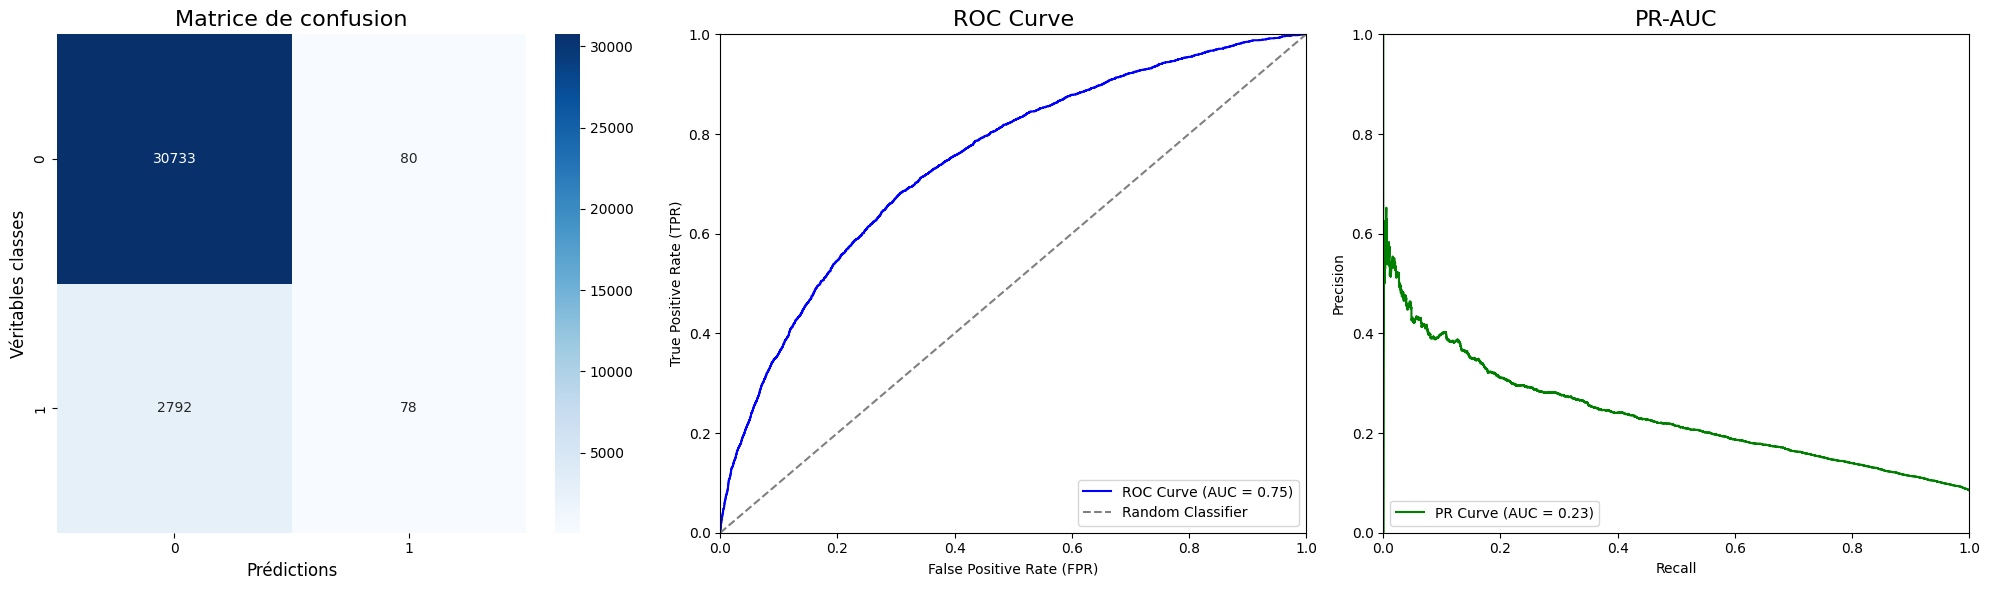

In [11]:
y_pred_lda = displayMetrics(LDA, X_test, y_test)

### <a id='toc1_2_2_'></a>[Resultat LGM](#toc0_)

[LightGBM] [Info] Number of positive: 2726, number of negative: 29272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3325
[LightGBM] [Info] Number of data points in the train set: 31998, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482205 -> initscore=-0.071211
[LightGBM] [Info] Start training from score -0.071211
[LightGBM] [Info] Number of positive: 2726, number of negative: 29272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3326
[LightGBM] [Info] Number of data points in the train set: 31998, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482205 -> initscore=-0.071211
[LightGBM] [Info] Start training from score -0.071211
[LightGBM] [In

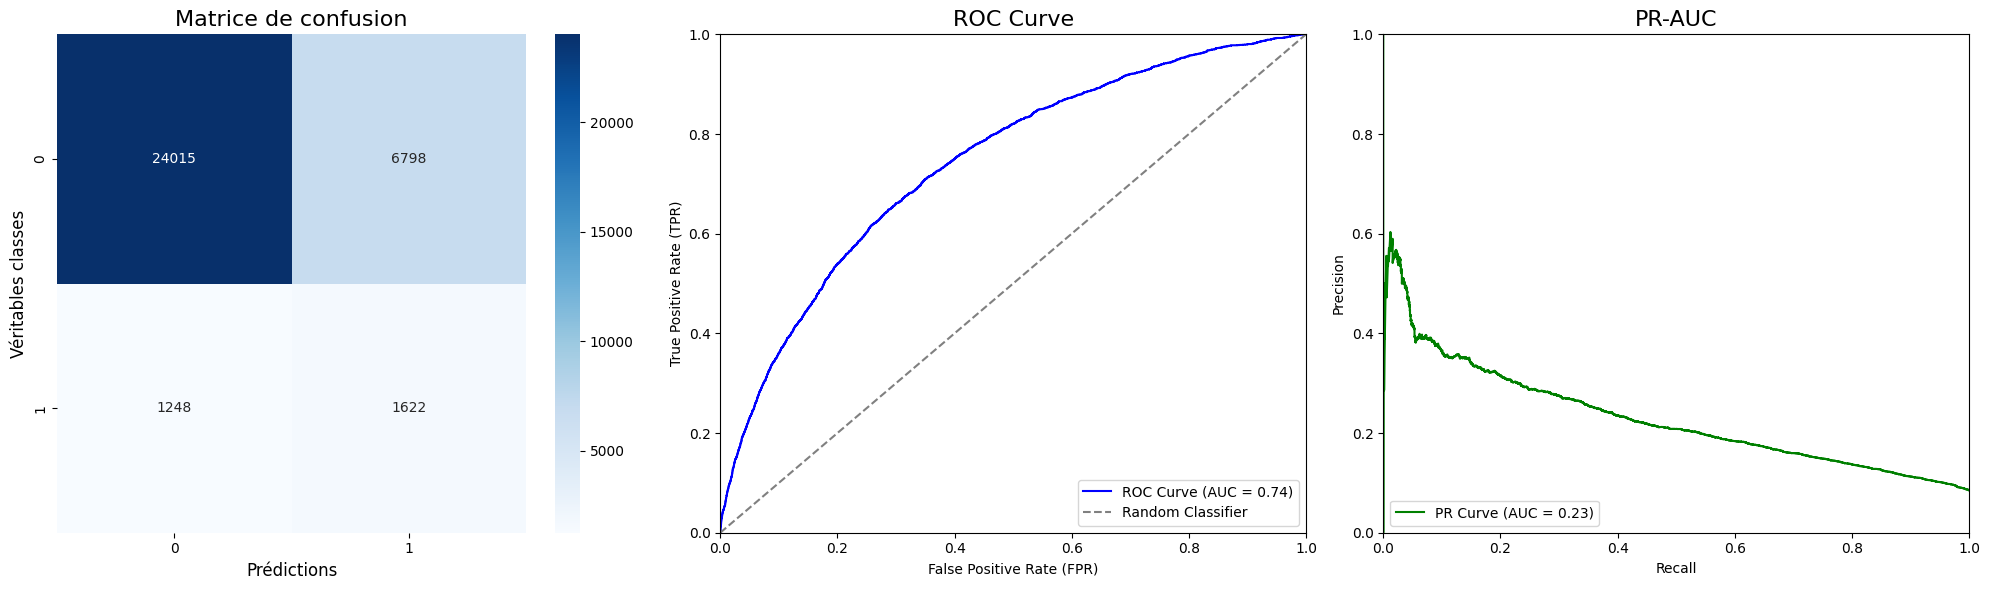

In [12]:
y_pred_lgm = displayMetrics(LGM, X_test, y_test)

### <a id='toc1_2_3_'></a>[Resultat NB](#toc0_)

Accuracy: 0.8560
F1 Score: 0.0687
Recall: 0.0624
Precision: 0.0765
Cohen's Kappa: -0.0085
MCC: -0.0085
ROC AUC: 0.5870
PR AUC: 0.1021


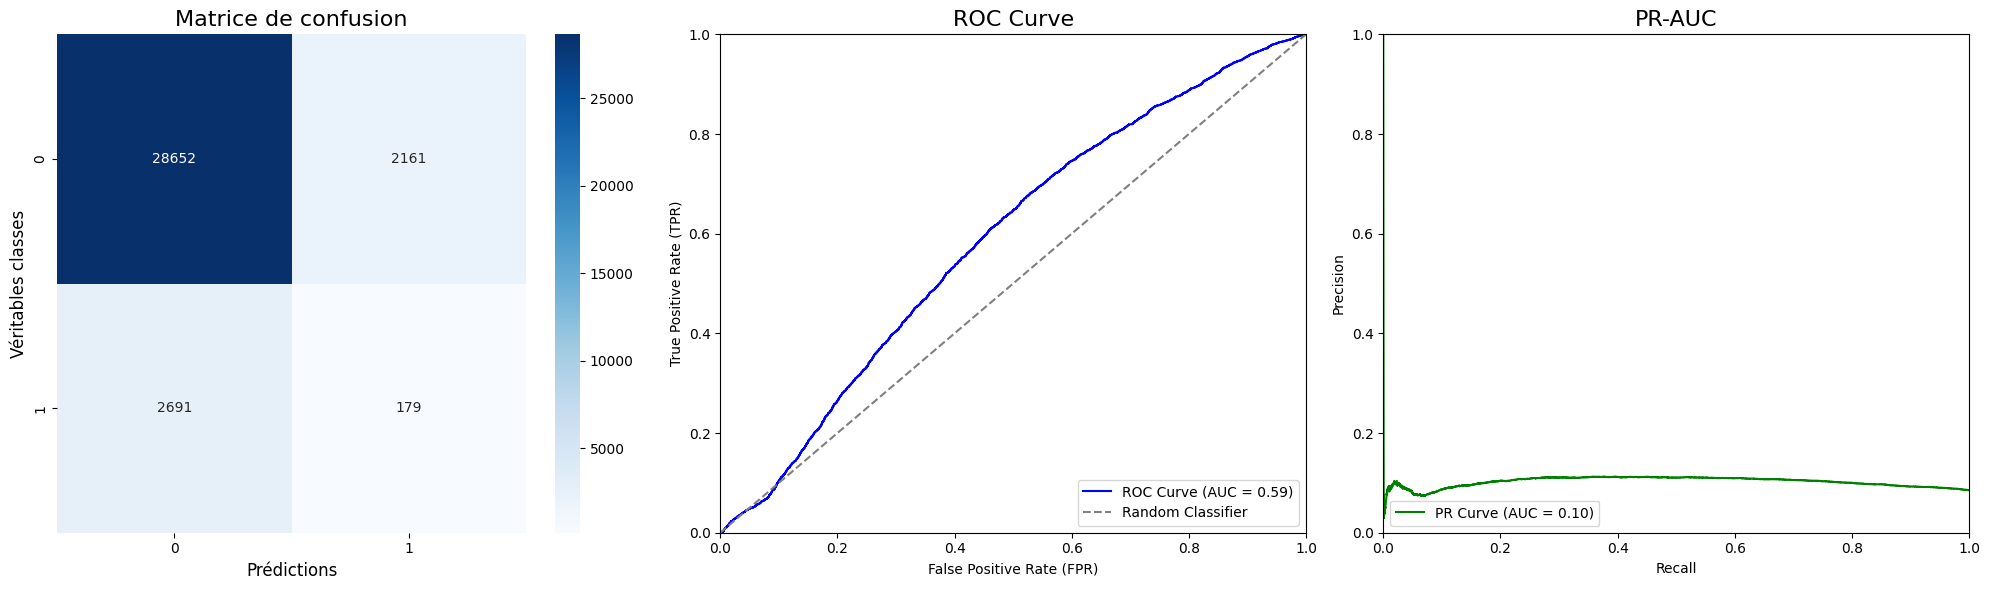

In [13]:
y_pred_nb = displayMetrics(NB, X_test, y_test)

Le modèle qui obtient les meilleures resultat est donc pour le moment LGM qui obtient les meilleures metrics, cependant ce n'est pas un modèle qui est très optimal et performant, nous allons donc passer a la deuxieme etape, l'optimisation des hyperparamètres pour voir si nous pouvons avoir une amelioration significative de notre modèle 

# <a id='toc2_'></a>[Optimisation des hyperparametres](#toc0_)

## <a id='toc2_1_'></a>[Optuna](#toc0_)

In [14]:
# import optuna
# # Fonction objective à optimiser
# def objective(trial):
#     param = {
#         'num_leaves': trial.suggest_int('num_leaves', 20, 100),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
#     }

#     model = LGBMClassifier(**param)
#     scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
#     return scores.mean()

# # Configurer le logger d'Optuna pour limiter les logs
# # optuna.logging.set_verbosity(optuna.logging.WARNING)  # Limiter l'affichage des logs à WARNING

# # Créer l'étude (study)
# study = optuna.create_study(direction='maximize')

# # Optimisation
# study.optimize(objective, n_trials=20)

# # Afficher les meilleurs paramètres
# print("Best parameters:", study.best_params)


In [15]:
# # Entrainer le modèle avec les meilleurs params
# lgb_optimized = SC.train(LGBMClassifier(**study.best_params), X_train=X_train, y_train=y_train) 

In [16]:
# y_pred_lda = displayMetrics(lgb_optimized, X_test, y_test)

# <a id='toc3_'></a>[Explication du modèle avec SHAP](#toc0_)

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html

In [17]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import shap

# print the JS visualization code to the notebook
shap.initjs()

c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 4 - Construisez un modèle de scoring\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
explainer = shap.TreeExplainer(LGM)


In [19]:
shap_values = explainer(X_train)

In [20]:
explainer

In [21]:
shap_values

.values =
array([[-0.24457323,  0.12856033,  0.13903621, ...,  0.01324127,
         0.05229019, -0.03774893],
       [-0.58836181, -0.30013223,  0.13583586, ...,  0.00525564,
        -0.04741375,  0.0747546 ],
       [-0.17450175,  0.23497449, -0.22702712, ...,  0.00570615,
        -0.08450306,  0.07447048],
       ...,
       [ 0.34598935, -0.50472022,  0.07244486, ...,  0.02080587,
         0.56333466,  0.08973646],
       [-0.29850661, -0.11604723, -0.14540679, ..., -0.08916482,
        -0.05574472, -0.1295874 ],
       [ 0.7395107 , -0.09248728,  0.15697723, ...,  0.0243611 ,
         0.04837808, -0.12741203]])

.base_values =
array([-0.57002138, -0.57002138, -0.57002138, ..., -0.57002138,
       -0.57002138, -0.57002138])

.data =
array([[ 0.5954562 ,  0.49030483,  0.10132928, ...,  7.        ,
         0.11933483,  6.66285932],
       [ 0.70620511,  0.64340412,  0.10887958, ..., 13.        ,
         0.03242673,  5.36288881],
       [ 0.50648424,  0.42643057,  0.060016  , ..., 10

## Explication Globale

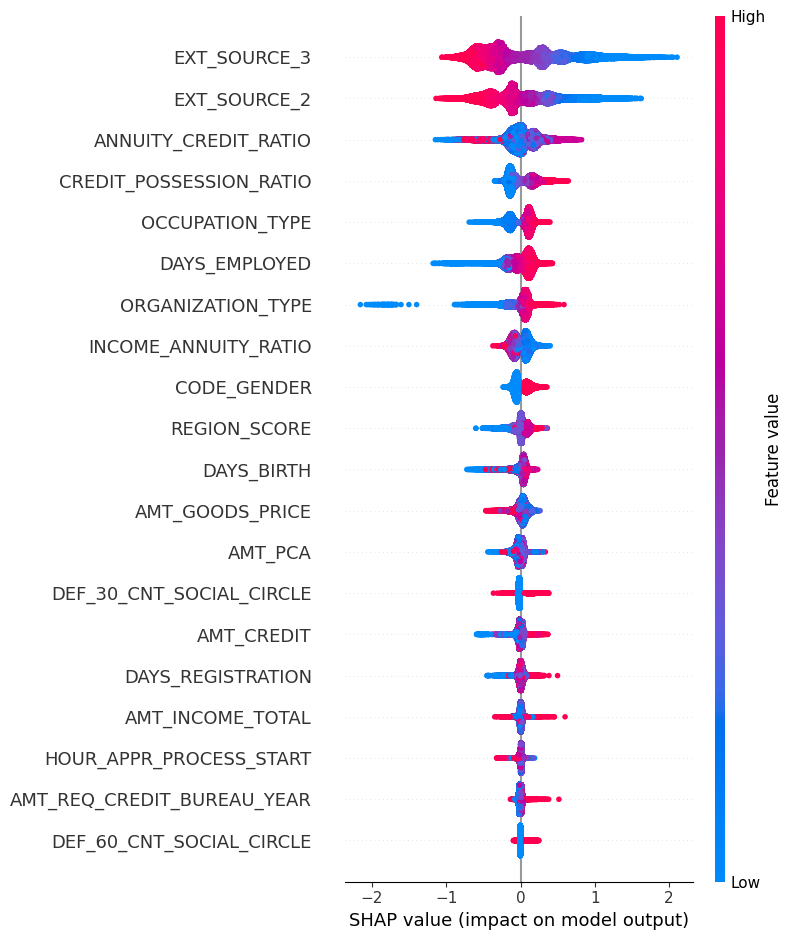

In [22]:
shap.summary_plot(shap_values, X_train)

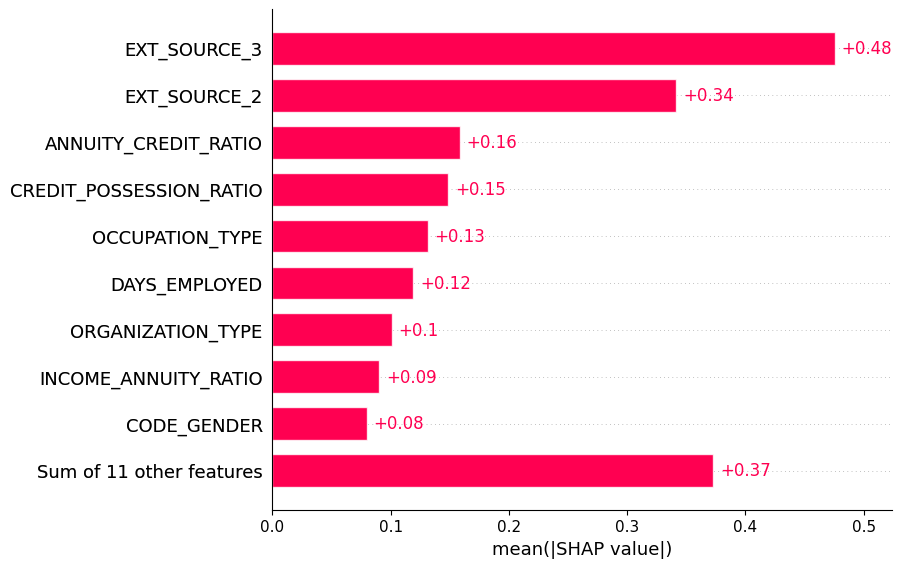

In [23]:
shap.plots.bar(shap_values.abs.mean(0))

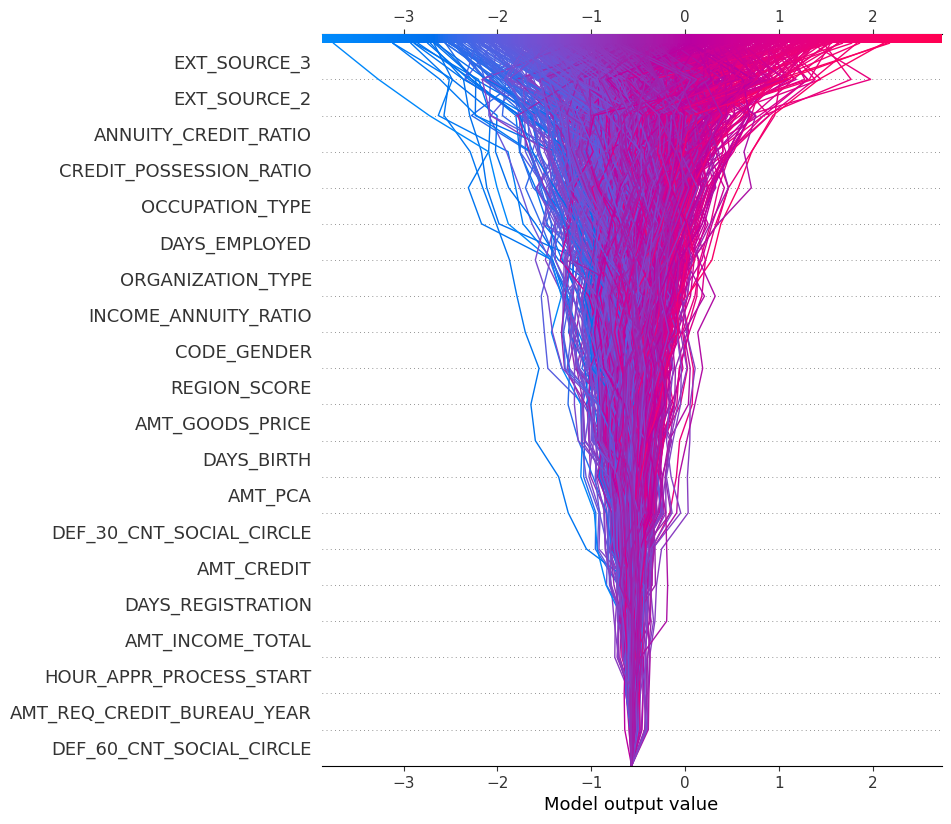

In [24]:
# Exemple : Individu à expliquer
individu = [i for i in range(1000)]

# Valeurs SHAP pour cet individu
shap_values_ind = shap_values[individu].values  # Accéder aux valeurs sous-jacentes de l'objet SHAP

# Conversion en float64
shap_values_ind = shap_values_ind.astype('float64')

# Valeur de base (expected value)
base_value = float(explainer.expected_value)  # S'assurer que la base est aussi en float

# Données de l'individu (features)
features = X_train.iloc[individu].astype('float64')  # Conversion des données en float64

# Création du decision plot
shap.decision_plot(
    base_value=base_value,               # Valeur de base
    shap_values=shap_values_ind,         # Valeurs SHAP de l'individu
    feature_names=X_train.columns.tolist(),  # Noms des caractéristiques
    feature_order='importance'           # Tri des caractéristiques (optionnel)
)


In [ ]:
# Correlation entre variable avec shap
shap.plots.heatmap(shap_values[:10000])  # Première tranche de 100 observations


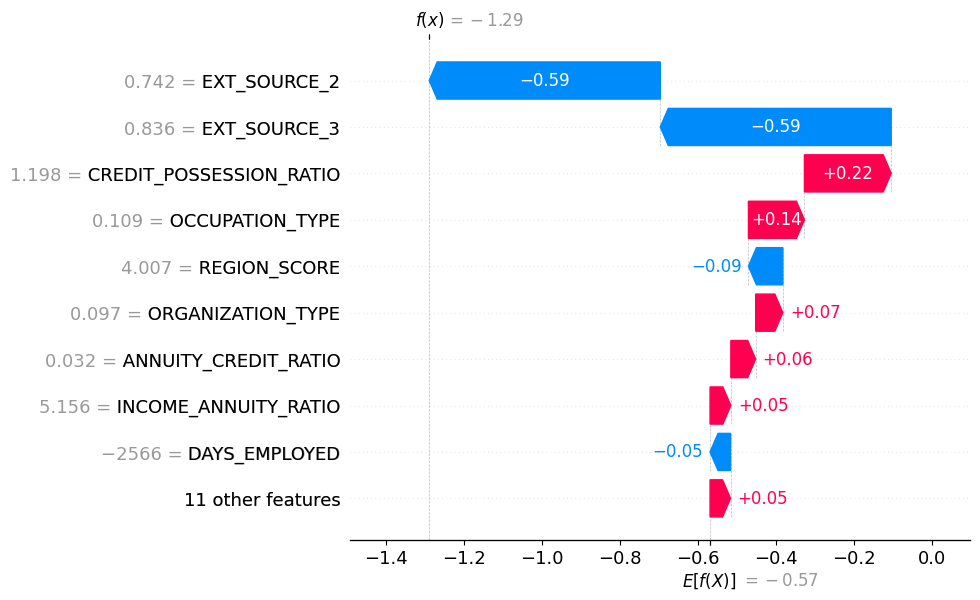

In [ ]:
shap.plots.waterfall(shap.Explanation(values=shap_values[1000], base_values=explainer.expected_value, data=X_train.iloc[1000], feature_names=X_train.columns.tolist()))

## Explication Locale

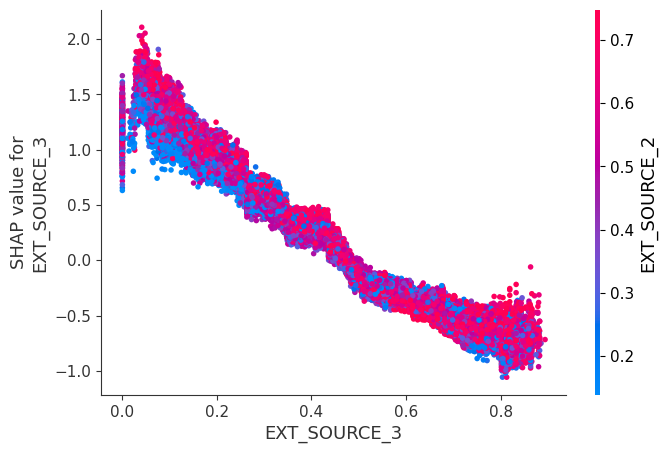

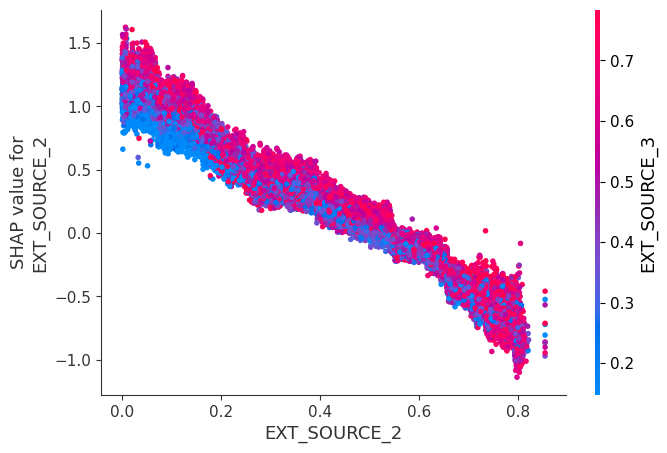

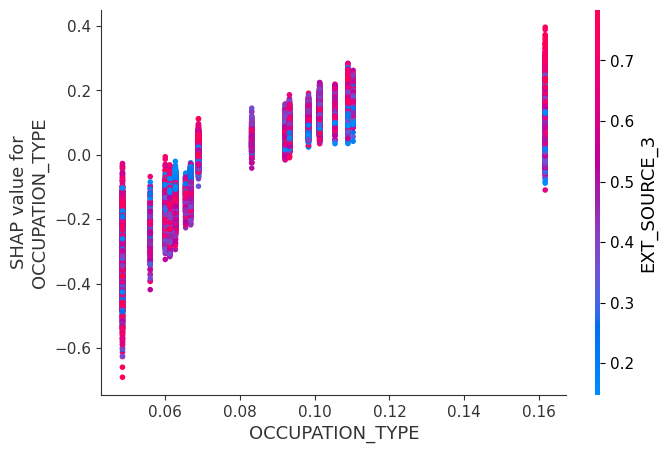

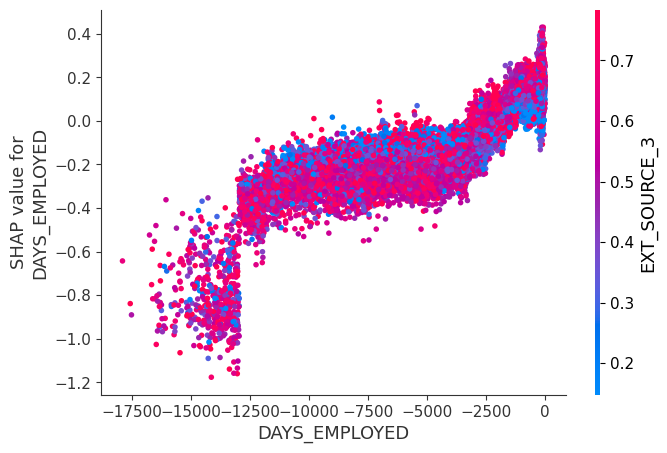

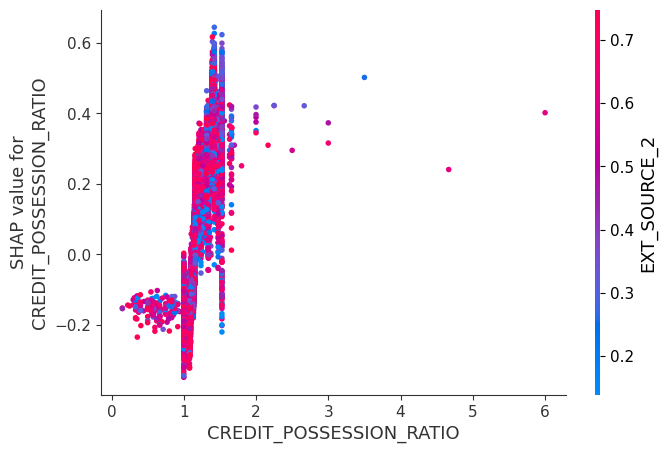

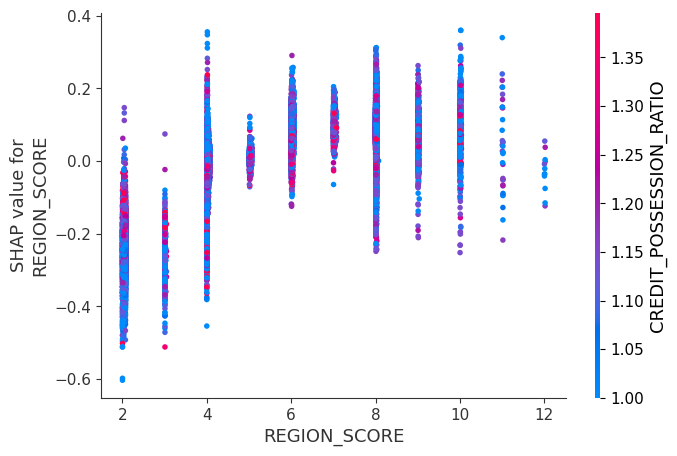

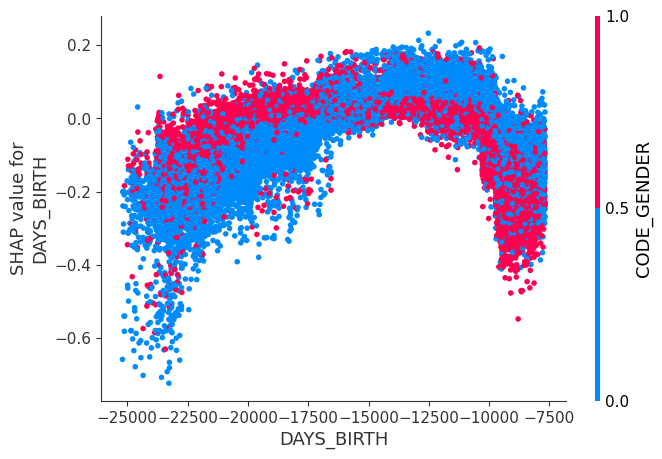

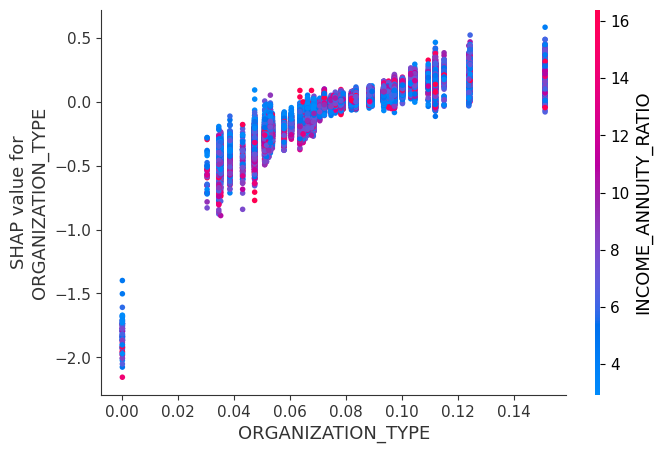

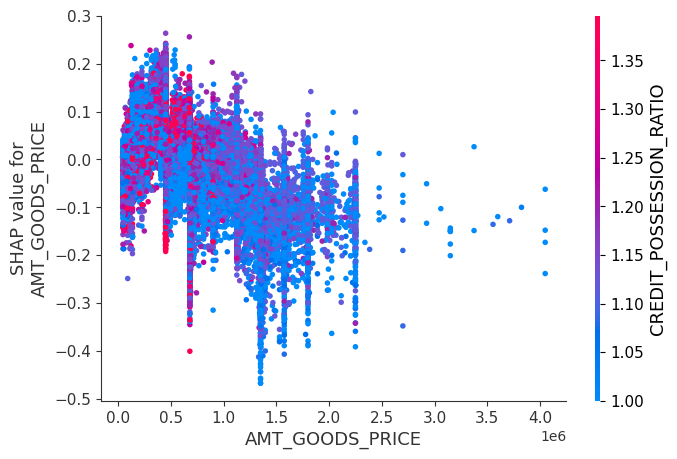

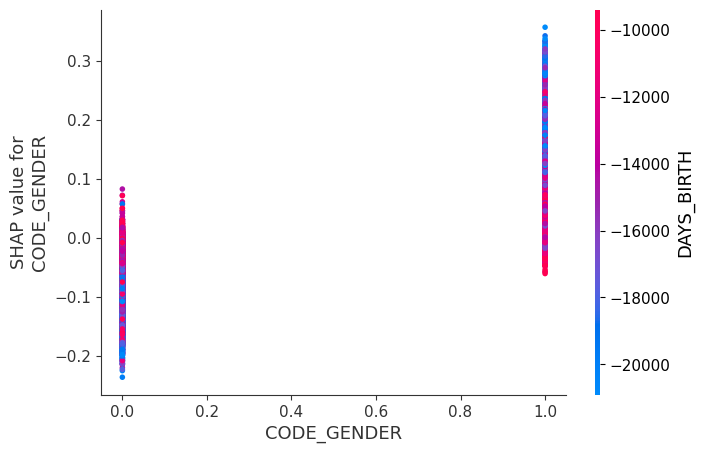

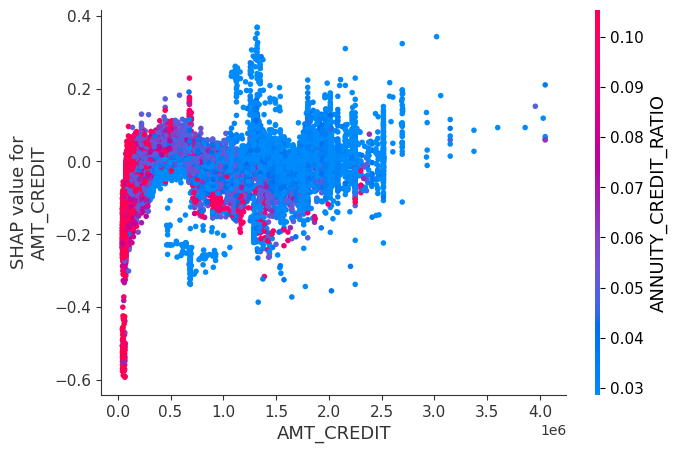

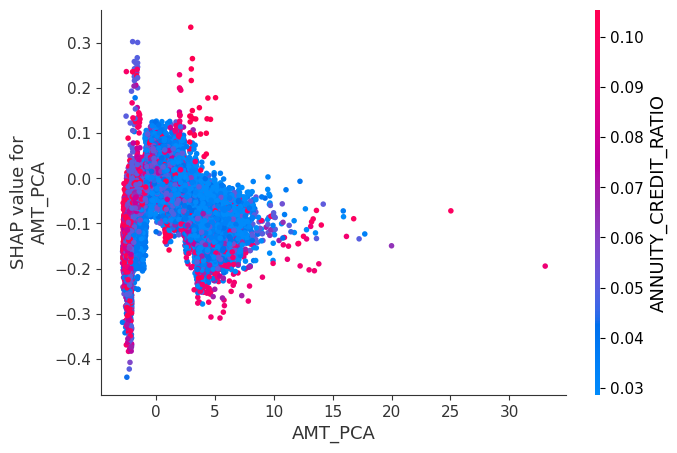

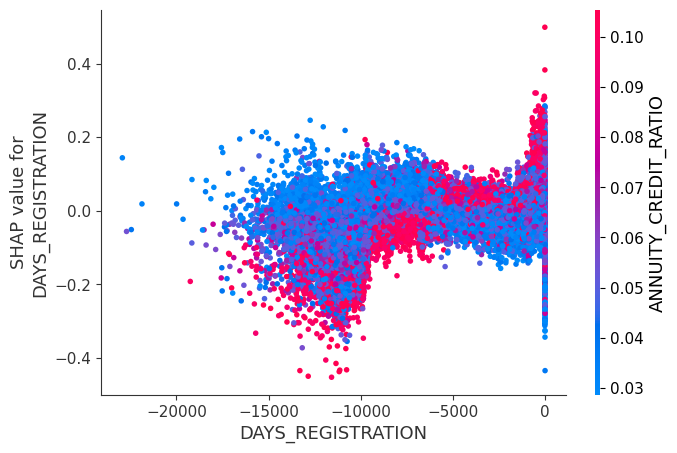

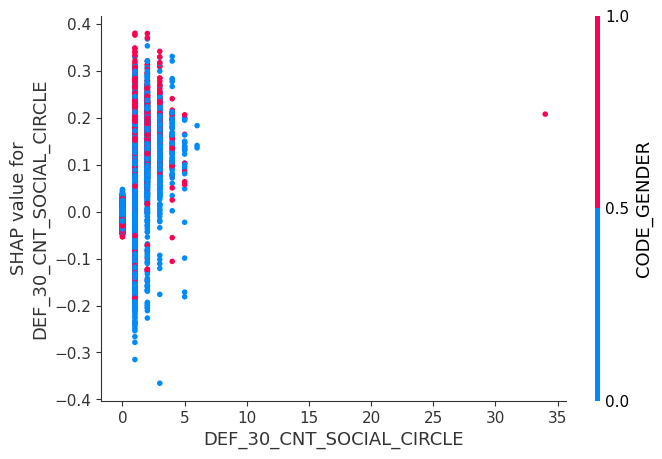

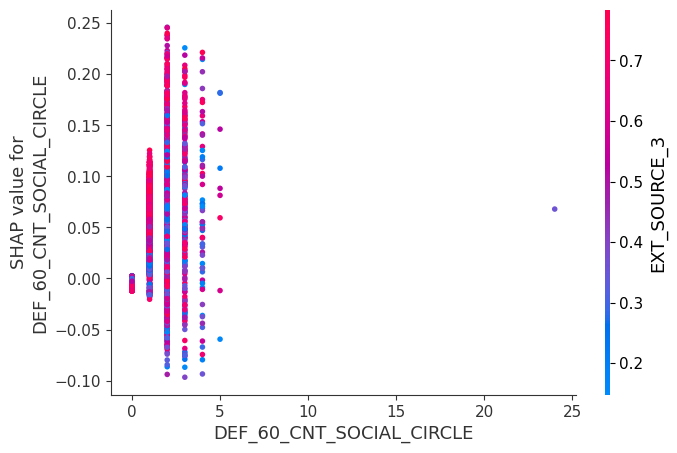

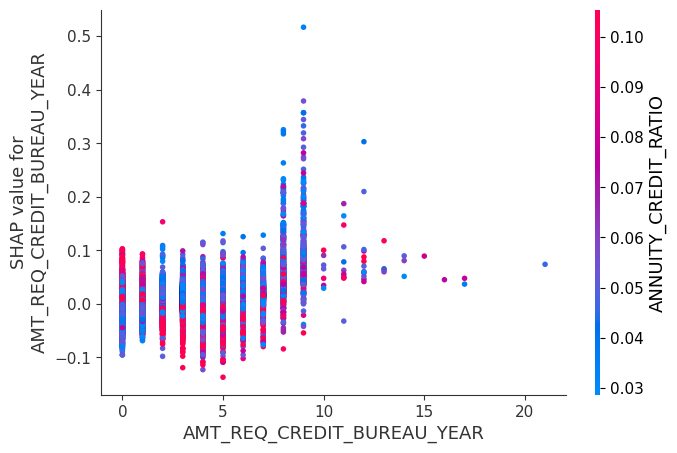

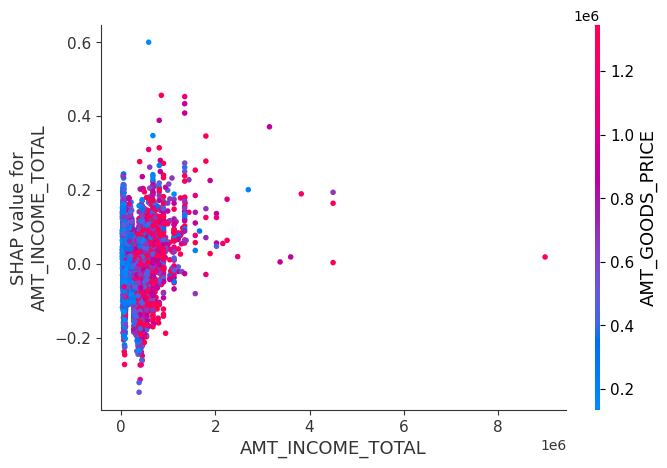

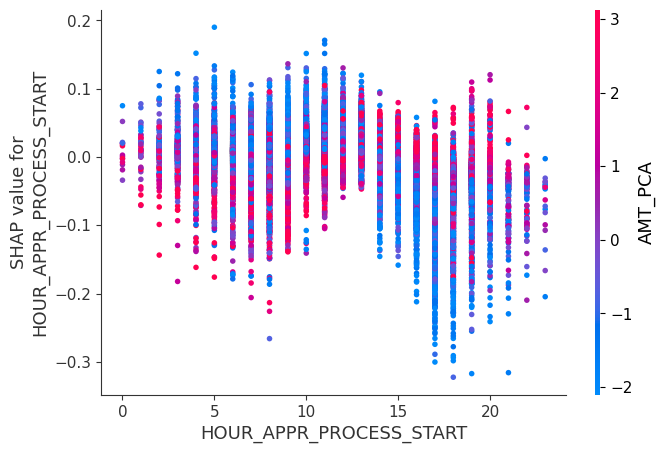

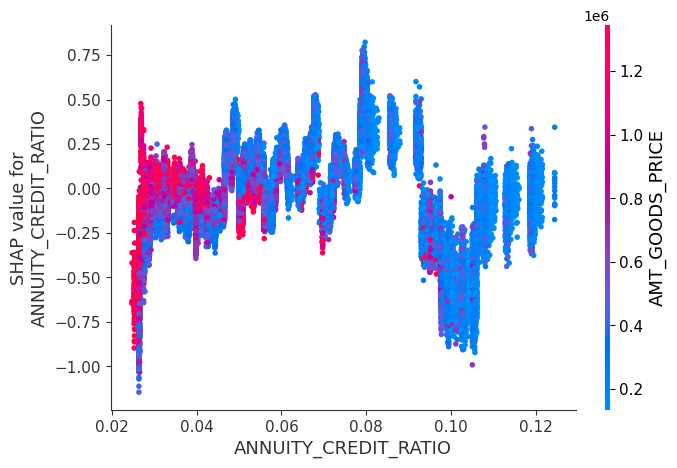

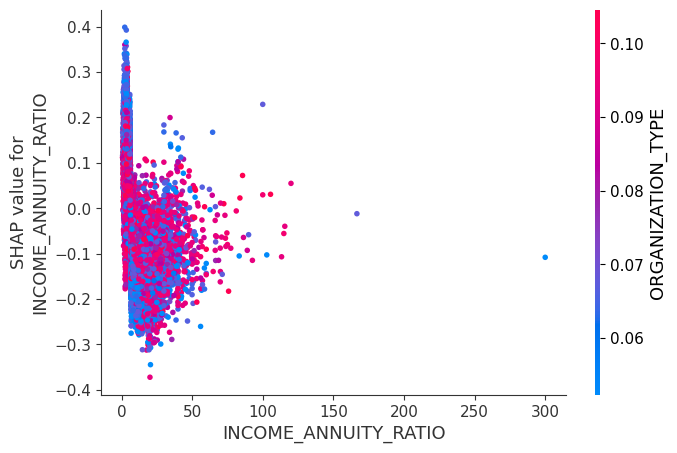

In [28]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values.values, X_train, display_features=X_train)

# Explication Locale